In [37]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm

In [38]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [39]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        # 初始化权重
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            module.bias.data.zero_()
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))  #均值
        std = F.softplus(self.fc_std(x)) + 1e-3  #标准差
        return mu, std

In [40]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [41]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [42]:
class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

        self.action_dim = action_dim

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        # print(action.shape)
        return action.cpu().numpy()[0]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 确保动作维度正确
        actions = actions.view(-1, self.action_dim)  # 重塑为 [batch_size, action_dim]

        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        # advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        mu, std = self.actor(states)
        # 确保均值和标准差都是有效的数值
        mu = torch.nan_to_num(mu, nan=0.0, posinf=1.0, neginf=-1.0)
        std = torch.nan_to_num(std, nan=1e-3, posinf=1.0, neginf=1e-3)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            mu = torch.nan_to_num(mu, nan=0.0, posinf=1.0, neginf=-1.0)
            std = torch.nan_to_num(std, nan=1e-3, posinf=1.0, neginf=1e-3)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
    
    def save_model(self, path):
        """保存模型"""
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            'gamma': self.gamma,
            'lmbda': self.lmbda,
            'epochs': self.epochs,
            'eps': self.eps
        }, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path):
        """加载模型"""
        checkpoint = torch.load(path)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
        self.gamma = checkpoint['gamma']
        self.lmbda = checkpoint['lmbda']
        self.epochs = checkpoint['epochs']
        self.eps = checkpoint['eps']
        print(f"Model loaded from {path}")

In [43]:
class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        # advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps,
                                1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [44]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 10000
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'HalfCheetah-v5'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
print(state_dim)
print(action_dim)
# agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)
# return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

17
6


In [45]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'terminated': [], 'truncated': [], 'dones': [] }
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['terminated'].append(terminated)
                transition_dict['truncated'].append(truncated)
                done = terminated or truncated
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)
        agent.save_model(f'./PPO_model/ppo_model_{i}.pth')

Iteration 0: 100%|██████████| 1000/1000 [15:12<00:00,  1.10it/s, episode=1000, return=-42163.398]


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 1: 100%|██████████| 1000/1000 [13:44<00:00,  1.21it/s, episode=2000, return=-2517.581] 


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 2: 100%|██████████| 1000/1000 [18:51<00:00,  1.13s/it, episode=3000, return=-4219.127]


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 3: 100%|██████████| 1000/1000 [17:05<00:00,  1.03s/it, episode=4000, return=-4351.342] 


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 4: 100%|██████████| 1000/1000 [19:19<00:00,  1.16s/it, episode=5000, return=-2457.259] 


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 5: 100%|██████████| 1000/1000 [13:30<00:00,  1.23it/s, episode=6000, return=-3210.362]  


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 6: 100%|██████████| 1000/1000 [11:15<00:00,  1.48it/s, episode=7000, return=-2471.139]  


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 7: 100%|██████████| 1000/1000 [10:40<00:00,  1.56it/s, episode=8000, return=-2495.084]


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 8: 100%|██████████| 1000/1000 [11:17<00:00,  1.48it/s, episode=9000, return=-2437.927]  


Model saved to ./PPO_model/ppo_model_{i}.pth


Iteration 9: 100%|██████████| 1000/1000 [10:27<00:00,  1.59it/s, episode=10000, return=-2320.837]

Model saved to ./PPO_model/ppo_model_{i}.pth


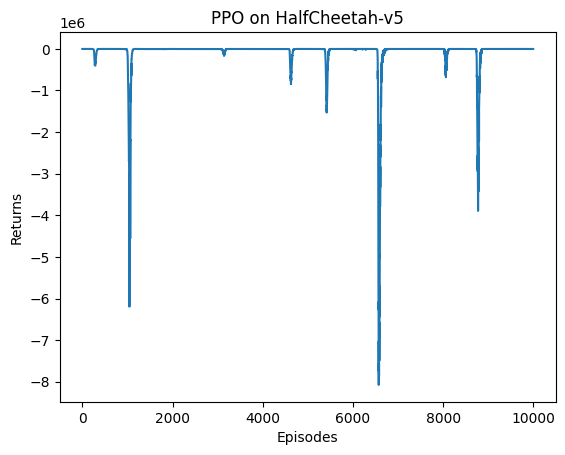

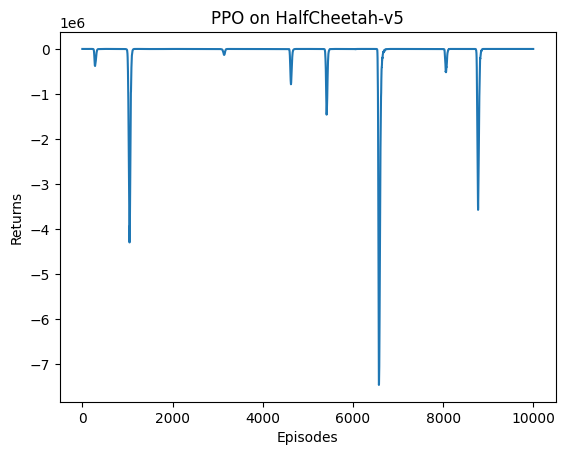

In [46]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()